In [22]:
from lib.functions0 import *
from lib.utility import *
import numpy as np
from scipy.linalg import expm
from qiskit.utils.mitigation.fitters import CompleteMeasFitter
from qiskit.ignis.mitigation.measurement import  complete_meas_cal
from qiskit import Aer, assemble, QuantumCircuit, QuantumRegister, ClassicalRegister, IBMQ, transpile, execute
from qiskit.providers.aer import AerSimulator, QasmSimulator
from qiskit.opflow import Zero, One, I, X, Y, Z
from qiskit.ignis.verification.tomography import state_tomography_circuits, StateTomographyFitter
from qiskit.quantum_info import state_fidelity
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2
import warnings
warnings.filterwarnings('ignore')
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q-community',
                            group='ibmquantumawards', 
                            project='open-science-22')

backend_sim_jakarta = QasmSimulator.from_backend(provider.get_backend('ibmq_jakarta'))
backend_real_jakarta = provider.get_backend('ibmq_jakarta')
backend_sim = Aer.get_backend('qasm_simulator')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


ibmqfactory.load_account:WARNING:2022-04-09 22:51:32,964: Credentials are already in use. The existing account in the session will be replaced.


In [23]:
n_steps=100
time=np.pi/5
#initial_state={"110": 1}
shots = 32000
backend = backend_sim_jakarta

X = np.array([[0,1],[1,0]])  #defining the pauli matrices
Y = np.array([[0,-1j],[1j,0]])
Z = np.array([[1,0],[0,-1]])
Id = np.eye(2)

# defining the hamiltonian divided in: 
#       - H1: first two qubits interactions.
#       - H2: second two qubits interactions.

H1 = np.kron(X, np.kron(X,Id)) + np.kron(Y, np.kron(Y,Id)) + np.kron(Z, np.kron(Z,Id)) 
H2 = np.kron(Id, np.kron(X,X)) + np.kron(Id, np.kron(Y,Y)) + np.kron(Id, np.kron(Z,Z)) 

# building numerically the trotter step matrix, and the whole operator (trotter step)^n_steps.

trotter_step_matrix_= expm(-time/n_steps*H1*1j).dot(expm(-time/n_steps*H2*1j))
trotterized = np.linalg.matrix_power(trotter_step_matrix_, n_steps)
Matrix(trotterized).n(3, chop=True)

Matrix([
[0.309 - 0.951*I,                0,                 0,               0,               0,                 0,                0,               0],
[              0,  0.468 - 0.219*I,   0.371 - 0.519*I,               0, -0.53 - 0.213*I,                 0,                0,               0],
[              0,  0.375 - 0.507*I, -0.436 + 0.0748*I,               0, 0.371 - 0.519*I,                 0,                0,               0],
[              0,                0,                 0, 0.468 - 0.219*I,               0,   0.375 - 0.507*I, -0.534 - 0.225*I,               0],
[              0, -0.534 - 0.225*I,   0.375 - 0.507*I,               0, 0.468 - 0.219*I,                 0,                0,               0],
[              0,                0,                 0, 0.371 - 0.519*I,               0, -0.436 + 0.0748*I,  0.375 - 0.507*I,               0],
[              0,                0,                 0, -0.53 - 0.213*I,               0,   0.371 - 0.519*I,  0.468 - 0.219*I,  

In [24]:
A0 = trotterized[3, 6]
A1 = trotterized[5, 6]
A2 = trotterized[6, 6]

r1=float(atan2(im(A0),re(A0))+atan2(im(A2),re(A2)))/2
r2=0
f1=float(atan2(im(A2),re(A2))-atan2(im(A1),re(A1))-np.pi)/2
f2=float((atan2(im(A2),re(A2))-atan2(im(A0),re(A0)))/2-f1)
a1=float(acos(abs(A2)))
a2=float(acos(abs(A1)/sin(a1)))

M1_qc = fixed_magnetization_two_qubit_gate(r1,f1,a1)
M2_qc = fixed_magnetization_two_qubit_gate(r2,f2,a2)

## building the operator U gate

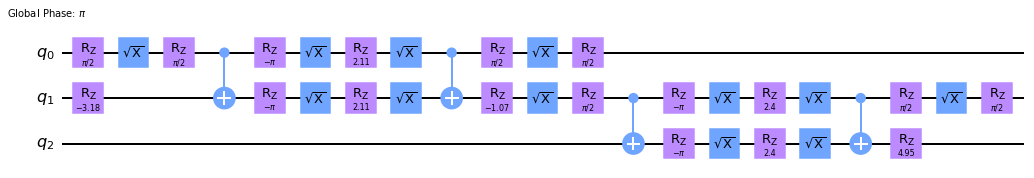

In [25]:

qr_U = QuantumRegister(3 ,name="q")
qc_U = QuantumCircuit(qr_U, name="U")

qc_U.append(M1_qc, [qr_U[0],qr_U[1]])
qc_U.append(M2_qc, [qr_U[1],qr_U[2]])

qc_U=transpile(qc_U, basis_gates=["cx","rz","x","sx"])
qc_U.draw(output="mpl")

In [26]:
U_ideal=matrix_from_circuit(qc_U, type="numpy")
Matrix(U_ideal)

Matrix([
[0.9057666294 + 0.4237768435*I,                              0,                             0,                             0,                             0,                              0,                              0,                             0],
[                            0,  0.4681540745 + 0.2190330815*I, 0.7889484898 + 0.3322898616*I,                             0,                             0,                              0,                              0,                             0],
[                            0, -0.3745018365 - 0.5072650329*I, 0.2378719778 + 0.2972213653*I,                             0, -0.6126538413 - 0.286639519*I,                              0,                              0,                             0],
[                            0,                              0,                             0, 0.4602256207 + 0.5750525497*I,                             0, -0.3166559495 - 0.1481523545*I, -0.5336389166 - 0.2247584019*I,            

## building the evolution circuit

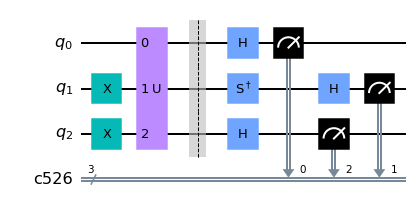

In [27]:
qr_evo = QuantumRegister(3, name="q")
qc_evo = QuantumCircuit(qr_evo, name="U")

qc_evo.x([qr_evo[1],qr_evo[2]])
qc_evo.append(qc_U, qr_evo)

qcs_tomo = state_tomography_circuits(qc_evo, qr_evo)
qcs_tomo[3].draw(output="mpl")

## building the calibration matrices

In [28]:
qr_cal = QuantumRegister(3)
cal_circ, state_labels = complete_meas_cal(qubit_list=[0,1,2], qr=qr_cal, circlabel='mcal')

## building the itself calibration circuit: *Circuit-Itself-Calibration (CIC)*

In [29]:
Number_of_tomography_basis = 3**3

circuits_calibration_itself = list(range(Number_of_tomography_basis))

for tomography_base in range(Number_of_tomography_basis):

    circuits_calibration_itself[tomography_base] = []

    for i in state_labels:

        cr_cal_itself = ClassicalRegister(3)
        qr_cal_itself = QuantumRegister(3)
        qc_cal_itself = QuantumCircuit(qr_cal_itself, cr_cal_itself, name=f"mcalcal_{i}") # changing the name to not have API contrast

        for k in range(3):
            if i[::-1][k] == "1":
                qc_cal_itself.x(qr_cal_itself[k])

        qc_cal_itself.append(qc_U, qr_cal_itself)
        qc_cal_itself.measure(qr_cal_itself, cr_cal_itself)

        circuits_calibration_itself[tomography_base].append(qc_cal_itself)

    


## building the identity calibration circit: *Noisy-Identity-Calibration (NIC)*

In [30]:
calib_circuits_identity = []

for i in state_labels:

    cr_cal_id = ClassicalRegister(3)
    qr_cal_id = QuantumRegister(3)
    qc_cal_id = QuantumCircuit(qr_cal_id, cr_cal_id, name=f"mcalcal_{i}")

    qc_cal_id.append(qc_U, qr_cal_id)

    for k in range(3):
        if i[::-1][k] == "1":
            qc_cal_id.x(qr_cal_id[k])
        
    qc_cal_id.measure(qr_cal_id, cr_cal_id)

    calib_circuits_identity.append(qc_cal_id)

## execution of the circuits

In [31]:
job_tomo=execute(qcs_tomo, backend, shots=shots, initial_layout=[1,3,5])

job_cal_our_identity=execute(calib_circuits_identity, backend = backend, shots=shots, initial_layout=[1,3,5])

jobs_cal_our_itself = []
for circuit_calibration_itself in circuits_calibration_itself:
    job_cal_our_itself=execute(circuit_calibration_itself, backend = backend, shots=shots, initial_layout=[1,3,5])
    jobs_cal_our_itself.append(job_cal_our_itself)

job_cal_qiskit=execute(cal_circ, backend, shots=shots, initial_layout=[1,3,5])

## building the matrices of the probabilies for the qiskit, identity and circuit-itself calibrations

In [32]:
meas_fitter_identity = CompleteMeasFitter(job_cal_our_identity.result(), state_labels=state_labels)

meas_fitter_itself_list = []
for job_cal_our_itself in jobs_cal_our_itself:
    meas_fitter_itself_list.append(CompleteMeasFitter(job_cal_our_itself.result(), state_labels=state_labels))

meas_fitter_qiskit = CompleteMeasFitter(job_cal_qiskit.result(), state_labels=state_labels)

## building the calibration matrix for each circuit of the tomography

In [33]:
U_tilde_identity=meas_fitter_identity.cal_matrix

U_tilde_itself_list = []
for meas_fitter_itself in meas_fitter_itself_list:
    U_tilde_itself_list.append(meas_fitter_itself.cal_matrix)

U_tilde_qiskit=meas_fitter_qiskit.cal_matrix

In [34]:
def matrix_from_cirquit(qc, phase=0, type="sympy"):

    backend = Aer.get_backend('unitary_simulator')
    job = execute(qc, backend, shots=32000)
    result = job.result()
    A=result.get_unitary(qc, decimals=10)*np.exp(1j*phase)
    if type=="sympy":
        return Matrix(A)
    else:
        return A

## building the matrix of the tomography basis 


In [36]:
qr_basi = QuantumRegister(3)
qc_basi = QuantumCircuit(qr_basi)

qcs_basis = state_tomography_circuits(qc_basi, qr_basi)

In [ ]:
C_matrices_itself = []
C_matrices_identity = []

U_ideal_inv = np.linalg.inv(U_ideal)
U_ideal_inv_abs = np.abs(U_ideal_inv)**2

U_ideal_abs = np.abs(U_ideal)**2
U_ideal_abs_inv = np.linalg.inv(U_ideal_abs)

C_itself = np.dot(U_tilde_itself, U_ideal_abs_inv)
C_identity = U_tilde_identity
